# Connect-4 Policy Evaluation (Supervised CNet192 +  PPO)

Evaluates  **single-channel POV** models:

- **Supervised** `cnet192_best.pt` checkpoints
- **PPO** checkpoints (same `CNet192` policy/value heads)

It runs an evaluation suite against `EVAL_CFG` (fast) or `EVALUATION_OPPONENTS` (final),
alternating starts (keep game counts even so starts are balanced).

In [1]:
# Imports + device
from __future__ import annotations
from pathlib import Path
from typing import Dict, Callable, Tuple, Any, Optional, List
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

DEVICE: cuda


In [2]:
# Project imports

from C4.connect4_env import Connect4Env
from C4.eval_oppo_dict import EVALUATION_OPPONENTS, EVAL_CFG
from C4.fast_connect4_lookahead import Connect4Lookahead
from C4.CNet192 import CNet192, load_cnet192
from PPO.ppo_agent_eval import * 
from C4.connect4_board_display import display_final_boards_PPO

In [3]:
SEED = 666
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
PLOTS = "Plots/PPO/"

In [5]:
# Load policy checkpoint

model = "PPO_Models/MIX_11.pt"
#model = "SupervisedModels/EXPERT_3.pt"

CKPT_PATH = Path(model)  
TRAINING_SESSION = model.split("/")[-1].split(".")[0]
policy, ckpt = load_cnet192(CKPT_PATH, device=DEVICE, strict=True)
policy.eval()

print("Loaded:", CKPT_PATH)
print("cfg:", ckpt.get("cfg", {}))
print("TRAINING_SESSION:", TRAINING_SESSION)

Loaded: PPO_Models\MIX_11.pt
cfg: {'arch': 'cnet192', 'use_mid_3x3': True, 'input_channels': 1}
TRAINING_SESSION: MIX_11


In [6]:
Lookahead = Connect4Lookahead()

In [7]:
suite_df, row_df = evaluate_and_log_to_excel(
    policy=policy,
    opponents_cfg=EVALUATION_OPPONENTS,
    excel_path="EVAL_PPO_results.xlsx",
    run_tag=TRAINING_SESSION,
    device=DEVICE,
    lookahead=Lookahead,
    seed=SEED,
    episodes=0,
    progress=True,
)


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

In [8]:
display(suite_df)

,opponent,games,wins,losses,draws,win_rate,loss_rate,draw_rate,score,avg_plies
0,Random,200,193,7,0,0.965,0.035,0.0,0.965,14.355
1,Leftmost,100,100,0,0,1.000,0.000,0.0,1.000,10.500
2,Center,200,200,0,0,1.000,0.000,0.0,1.000,19.500
3,Lookahead-1,100,50,50,0,0.500,0.500,0.0,0.500,21.000
4,Lookahead-2,100,100,0,0,1.000,0.000,0.0,1.000,16.500
5,Lookahead-3,100,0,100,0,0.000,1.000,0.0,0.000,33.500
6,Lookahead-4,100,100,0,0,1.000,0.000,0.0,1.000,16.500
7,Lookahead-5,50,50,0,0,1.000,0.000,0.0,1.000,27.500
8,Lookahead-6,24,24,0,0,1.000,0.000,0.0,1.000,16.500
9,Lookahead-7,10,10,0,0,1.000,0.000,0.0,1.000,33.500


In [9]:
display(row_df)

,TIME [h],EPISODES,Random,Leftmost,Center,Lookahead-1,Lookahead-2,Lookahead-3,Lookahead-4,Lookahead-5,Lookahead-6,Lookahead-7,Lookahead-9,Lookahead-11,Lookahead-13
TRAINING_SESSION,,,,,,,,,,,,,,,
MIX_11,0.016224,0,0.965,1.0,1.0,0.5,1.0,0.0,1.0,1.0,1.0,1.0,0.5,0.0,0.0


📊 Plot saved to Plots/PPO/PPO-MIX_11-evaluation_plot.png


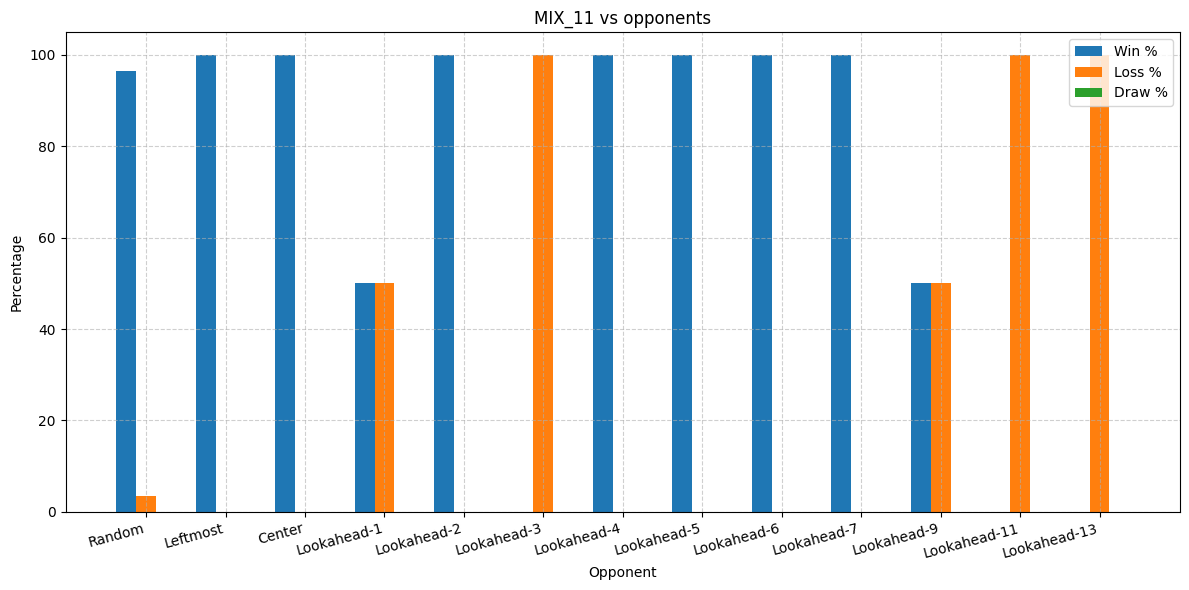

In [10]:
fig = plot_eval_bar_summary_from_suite_df(
    suite_df,
    model_name=TRAINING_SESSION,
    save_path=f"{PLOTS}PPO-{TRAINING_SESSION}-evaluation_plot.png",
)
import matplotlib.pyplot as plt
plt.show(fig)

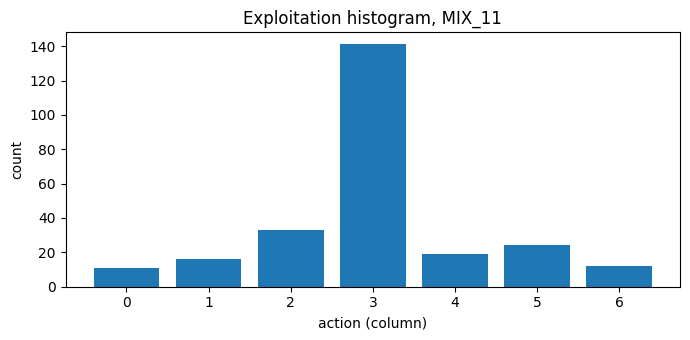

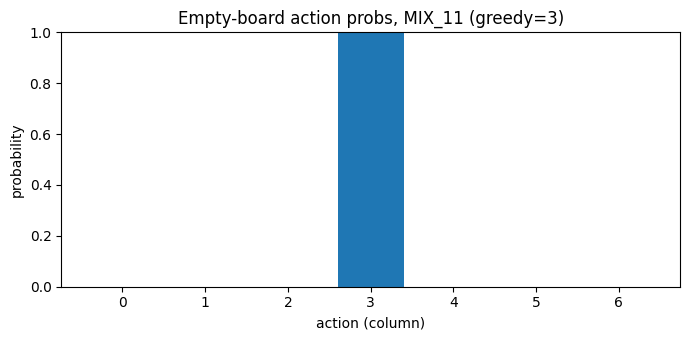

Exploit histogram (0..6): [11, 16, 33, 141, 19, 24, 12]
Frequencies: [0.043 0.062 0.129 0.551 0.074 0.094 0.047]


In [11]:
counts = exploitation_histogram(policy, device=DEVICE, n_states=256, rng_seed=0, max_random_plies=12)
fig1 = plot_exploitation_histogram(counts, model_name=TRAINING_SESSION)
fig2 = plot_empty_board_action_distribution(policy, device=DEVICE, model_name=TRAINING_SESSION, temperature=1.0)

import matplotlib.pyplot as plt
plt.show(fig1)
plt.show(fig2)

print("Exploit histogram (0..6):", counts.tolist())
print("Frequencies:", np.round(counts / max(1, counts.sum()), 3))

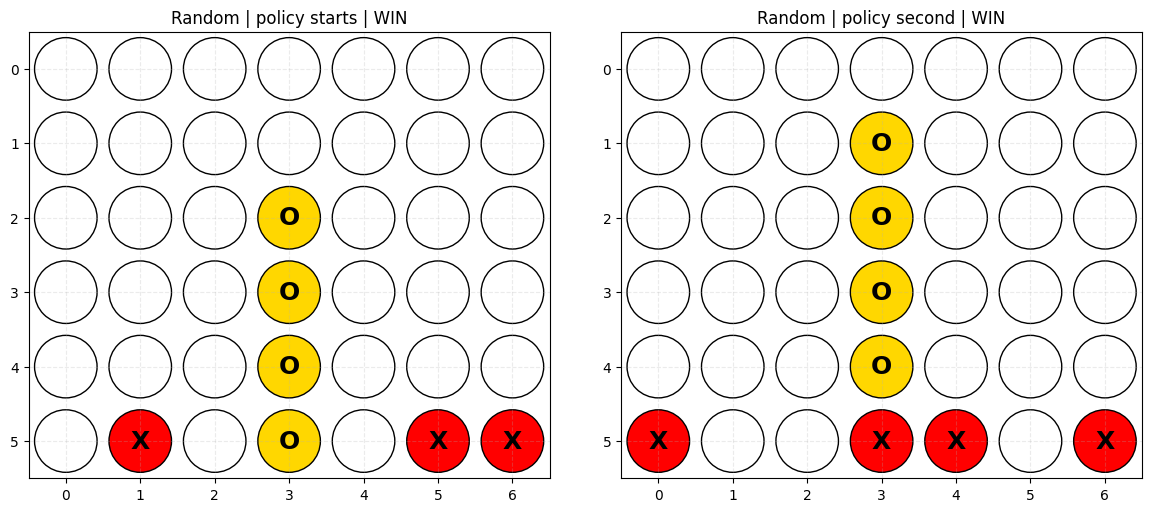

In [12]:
display_final_boards_PPO(policy, ["Random"])

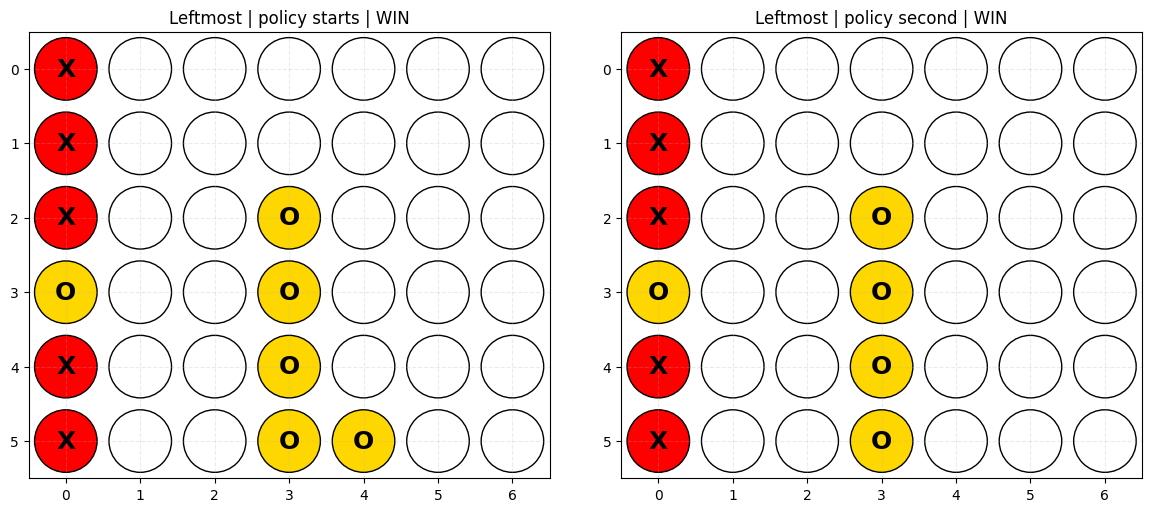

In [13]:
display_final_boards_PPO(policy, ["Leftmost"])

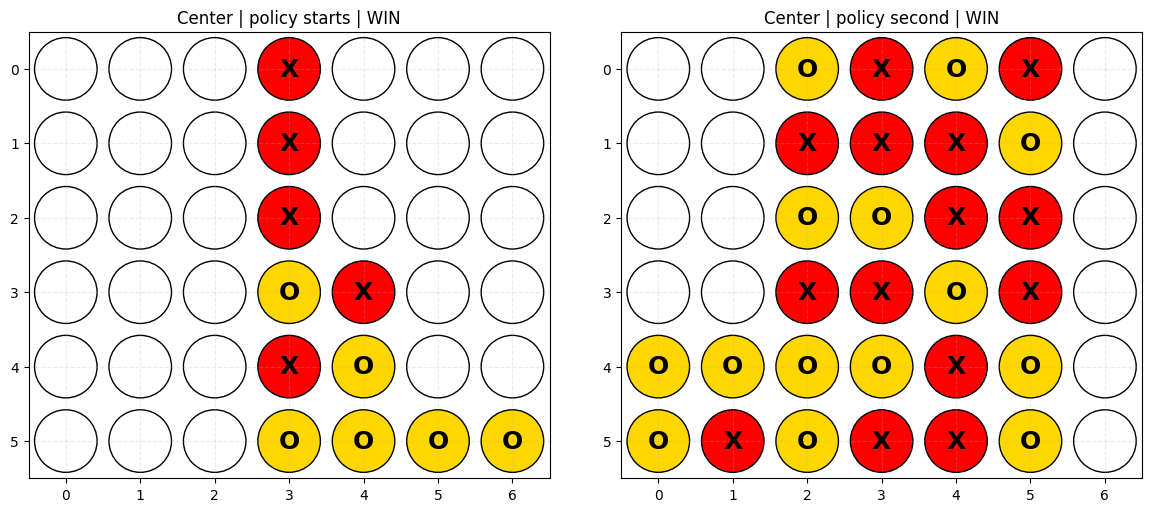

In [14]:
display_final_boards_PPO(policy, ["Center"])

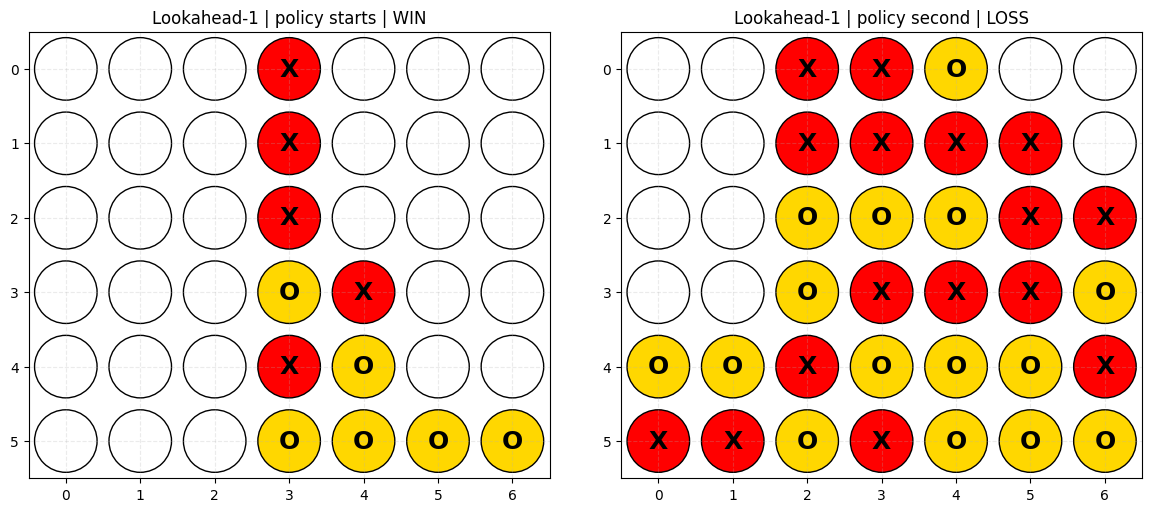

In [15]:
display_final_boards_PPO(policy, ["Lookahead-1"], lookahead = Lookahead)

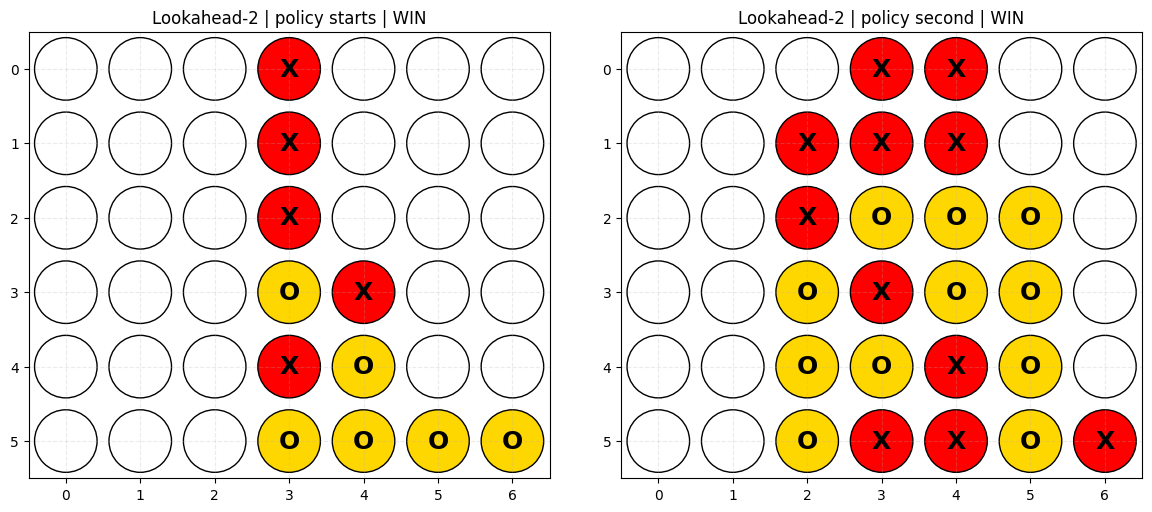

In [16]:
display_final_boards_PPO(policy, ["Lookahead-2"], lookahead = Lookahead)

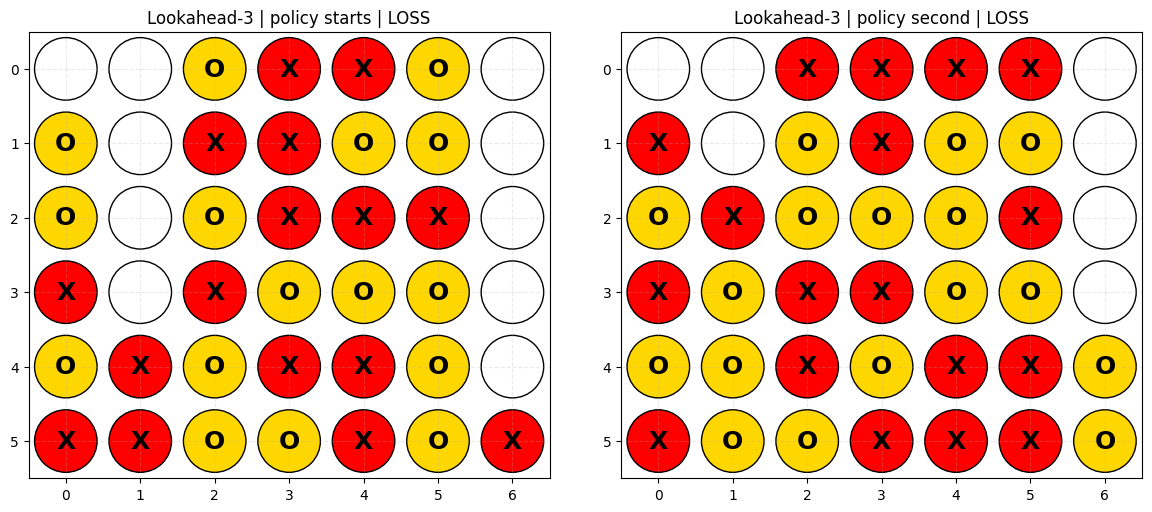

In [17]:
display_final_boards_PPO(policy, ["Lookahead-3"], lookahead = Lookahead)

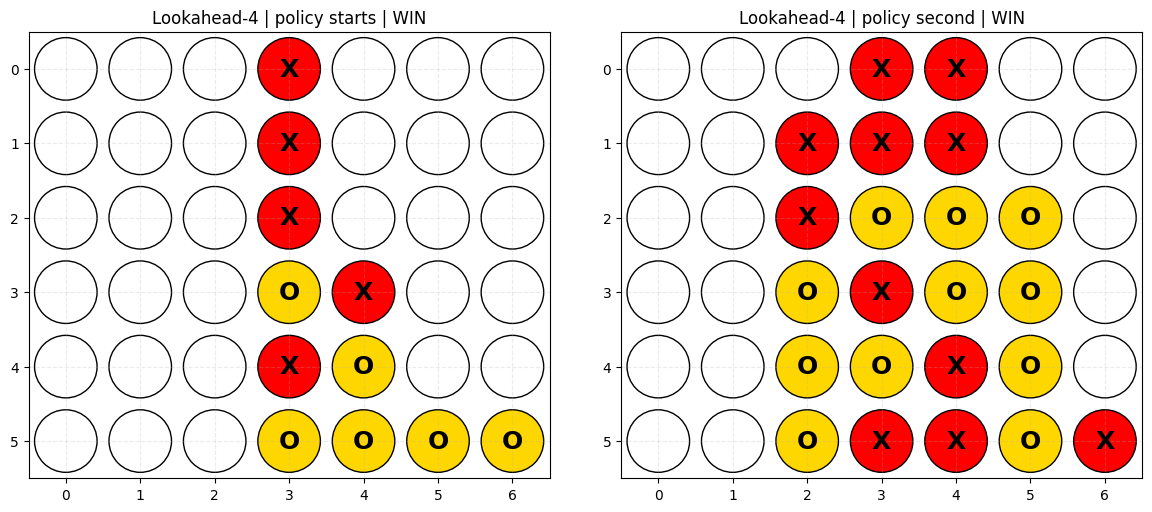

In [18]:
display_final_boards_PPO(policy, ["Lookahead-4"], lookahead = Lookahead)

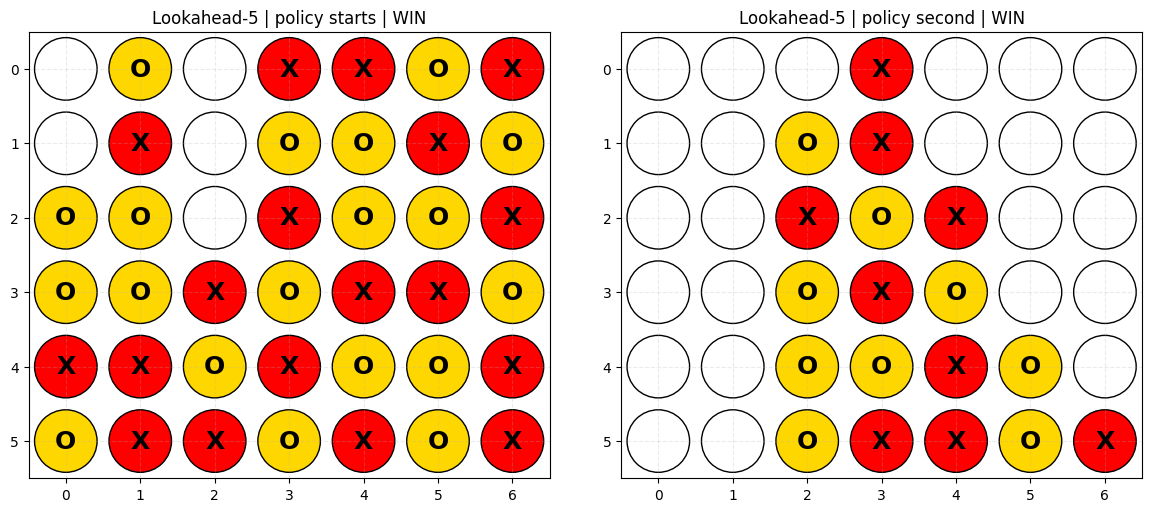

In [19]:
display_final_boards_PPO(policy, ["Lookahead-5"], lookahead = Lookahead)

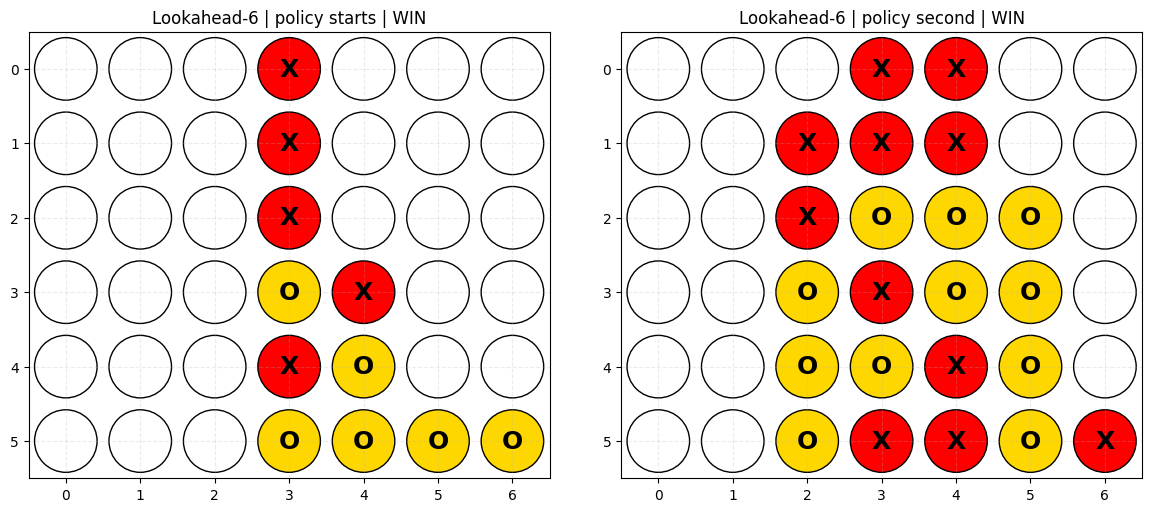

In [20]:
display_final_boards_PPO(policy, ["Lookahead-6"], lookahead = Lookahead)

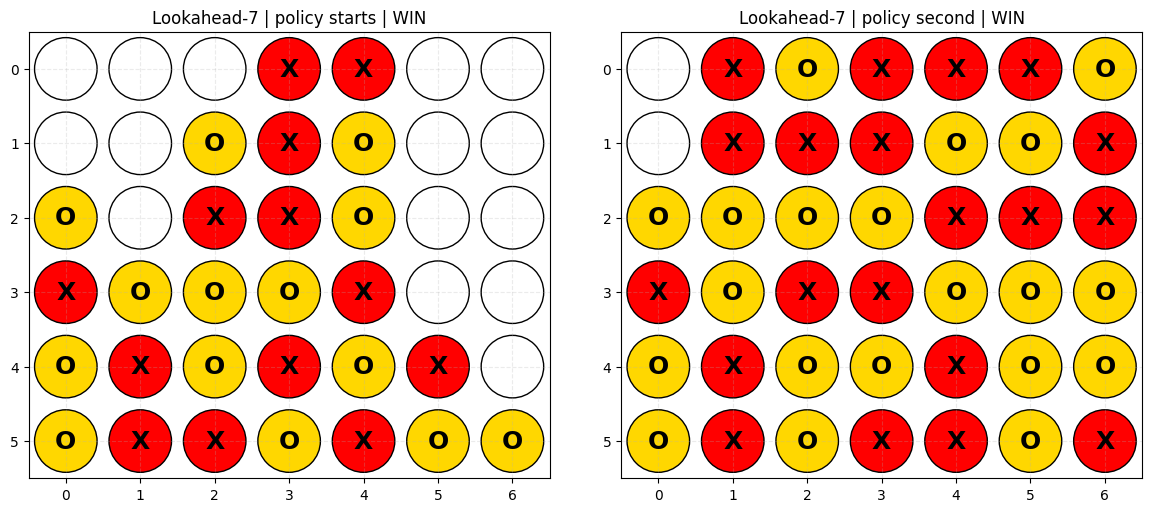

In [21]:
display_final_boards_PPO(policy, ["Lookahead-7"], lookahead = Lookahead)

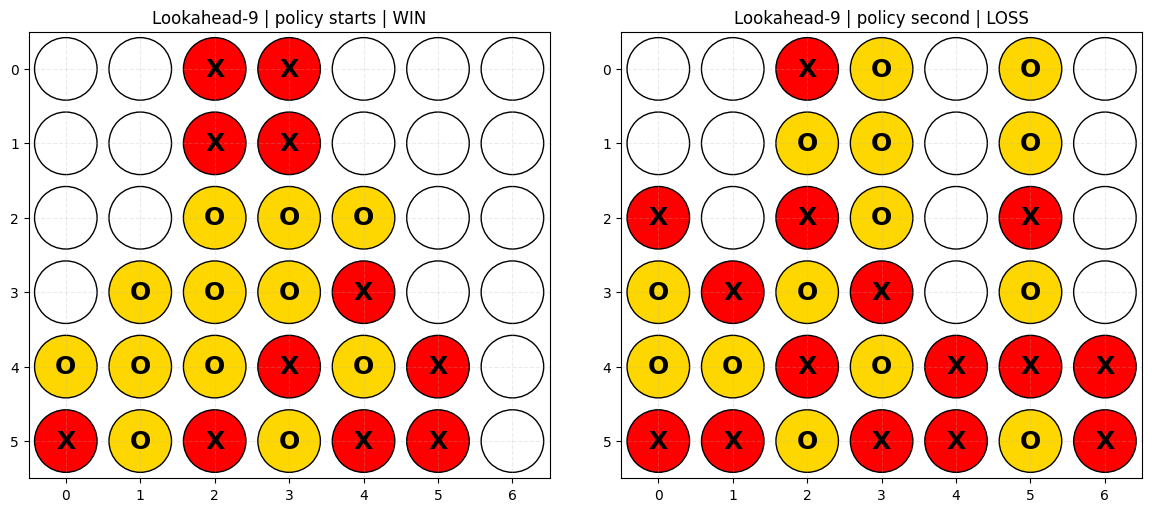

In [22]:
display_final_boards_PPO(policy, ["Lookahead-9"], lookahead = Lookahead)

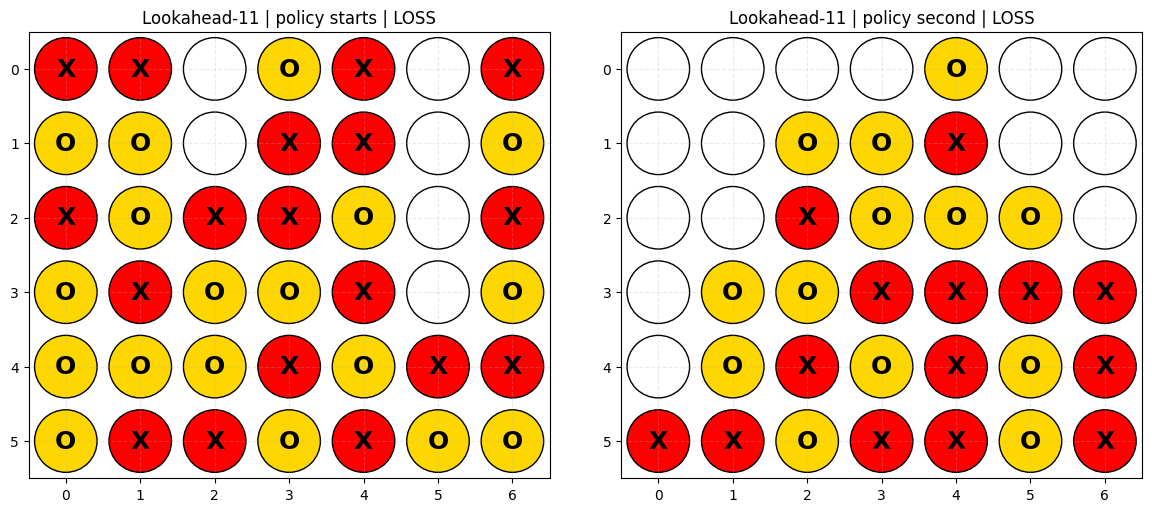

In [23]:
display_final_boards_PPO(policy, ["Lookahead-11"], lookahead = Lookahead)